# Data Analysis

# Interpretable Models

In this lecture we will cover the following:

+ How do we build trust in models that have to be released? 
+ Interpretable models <br>
** Models that explain themselves <br>
** Model-agnostic methods (can be applied to any model)<br>

Some references:

https://christophm.github.io/interpretable-ml-book/

LIME <br>
https://www.oreilly.com/content/introduction-to-local-interpretable-model-agnostic-explanations-lime/<br>
https://github.com/marcotcr/lime

SHAP <br>
https://github.com/slundberg/shap

### Interpretable data analysis

We can split approaches into:

1) Interpretable models: Models that explain themselves, e.g. <br>
++ Linear/Logistic Regression <br>
++ Decision Trees <br>

2) Model-agnostic methods: Can be applied to any learning model, e.g. <br>
++ Support Vector Machine <br>
++ Neural Network <br>

In interpretable models, we are mostly interested into the inner workings of the model.

In explainable models, we are mostly interested into understanding why certain decisions were made. 

### The dataset

Before we jump into the models, let's look at the dataset we are going to be using as a demo.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from sklearn.preprocessing import StandardScaler

from pdpbox import pdp, get_dataset, info_plots
import shap
import lime
from lime import lime_tabular

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from io import StringIO
#from sklearn.externals.six import StringIO  #will work only with 0.22
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

import eli5
from eli5.sklearn import PermutationImportance

In [2]:
data = pd.read_csv('heart.csv')
print(data.shape)
data.head()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
cols_meaning = ['age of patient', '1 = male, 0 = female', 'chest pain type', 'resting blood pressure (in mm Hg on admission to the hospital)', 'serum cholesterol in mg/dl', 'fasting blood sugar > 120 mg/dl (1 = true; 0 = false)', 'resting electrocardiographic results', 'maximum heart rate achieved', 'exercise induced angina (1 = yes; 0 = no)', 'ST depression induced by exercise relative to rest', 'the slope of the peak exercise ST segment', 'number of major vessels (0-3) colored by fluoroscopy', '3 = normal; 6 = fixed defect; 7 = reversable defect', 'heart disease = 1, no heart disease = 0']
cols_index = ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'y']

cols_dict = {'feature':data.columns, 'meaning':cols_meaning} 
cols_df = pd.DataFrame(index=cols_index, data=cols_dict)

pd.set_option('display.max_colwidth', -1)

cols_df

,feature,meaning
x0,age,age of patient
x1,sex,"1 = male, 0 = female"
x2,cp,chest pain type
x3,trestbps,resting blood pressure (in mm Hg on admission to the hospital)
x4,chol,serum cholesterol in mg/dl
x5,fbs,fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
x6,restecg,resting electrocardiographic results
x7,thalach,maximum heart rate achieved
x8,exang,exercise induced angina (1 = yes; 0 = no)
x9,oldpeak,ST depression induced by exercise relative to rest


In [4]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [5]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


<AxesSubplot: xlabel='target', ylabel='Density'>

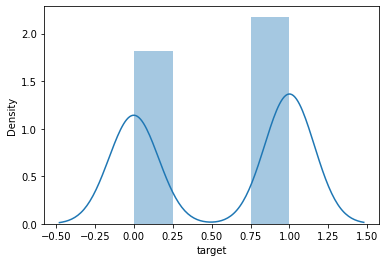

In [6]:
sn.distplot(data['target'])

In [7]:
data.isnull().any()

age         False
sex         False
cp          False
trestbps    False
chol        False
fbs         False
restecg     False
thalach     False
exang       False
oldpeak     False
slope       False
ca          False
thal        False
target      False
dtype: bool

In [8]:
y = data['target']
x = data.drop('target', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [9]:
pd.crosstab(data['sex'], data['target'])

target,0,1
sex,,
0,24,72
1,114,93


# 2. Interpretable models

## 2.1 Logistic (or Linear) Regression

### Why is Linear Regression interpretable?

In linear regression, we can use the coefficients (or weights) to find which features are the most important
e.g. if increase a feature (predictor) value by one unit and you keep all other features (predictors) fixed, then the prediction will increase by the coefficient value of the feature

$$
Y = \beta_0 + \beta_1 X_1 + ... + \beta_p X_p + \epsilon
$$

We interpret $\beta_j$ as the average effect on $Y$ of a one unit increase in $X_j$, ***holding all other predictors fixed***.

### Why is Logistic Regression intrepretable?

In logistic regression, things are bit more complicated but still make sense.

$$
\log \left( \frac{p(X)}{1-p(X)} \right) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_p X_p 
$$

or

$$
\frac{p(X)}{1-p(X)} = e ^ {\beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_p X_p}
$$

or

$$
p(X) = p(Y = 1 | \ X) = \frac{e^{\beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_p X_p}}{1+ e^{\beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_p X_p}}
$$

If I increase a predictor value by one unit (and ***keep all others fixed***), then the probability of the “positive” class changes by the odds ratio. Let's see it through an example:

Let’s say that the probability of success (“positive” class) of an event is 0.8. Then the probability of failure (“negative” class)  is 1 – 0.8 = 0.2.

The odds of success are defined as the ratio of the probability of success over the probability of failure. In our example, the odds of success are 0.8/0.2 = 4. That is to say that the odds of success are 4 to 1.

If the probability of success is 0.5, i.e., 50-50 percent chance, then the odds of success is 1 to 1 (the odds ratio of the coefficient is 1). Read more about this [here](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/).

Let's apply logistic regression to the `heart` dataset above.

In [10]:
model = LogisticRegression(random_state=10)
model.fit(x_train, y_train)

LogisticRegression(random_state=10)

In [11]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print('Accuracy on train:  ' + str(accuracy_score(y_train, y_train_pred)))
print('Recall on train:    ' + str(recall_score(y_train, y_train_pred)))

print('Accuracy on test:   ' + str(accuracy_score(y_test, y_test_pred)))
print('Recall on test:     ' + str(recall_score(y_test, y_test_pred)))

Accuracy on train:  0.8553719008264463
Recall on train:    0.9172932330827067
Accuracy on test:   0.8852459016393442
Recall on test:     0.90625


In [12]:
d = {'feature': x_train.columns, 'meaning': cols_meaning[:-1], 'coefficient': model.coef_[0], 'odds': np.exp(model.coef_[0])}
df = pd.DataFrame(index=cols_index[:-1], data=d)
df.sort_values(by='odds', ascending=False)

,feature,meaning,coefficient,odds
x2,cp,chest pain type,0.775056,2.170713
x10,slope,the slope of the peak exercise ST segment,0.618767,1.856637
x6,restecg,resting electrocardiographic results,0.535698,1.708640
x7,thalach,maximum heart rate achieved,0.027081,1.027451
x0,age,age of patient,0.007980,1.008012
x4,chol,serum cholesterol in mg/dl,-0.001414,0.998587
x5,fbs,fasting blood sugar > 120 mg/dl (1 = true; 0 = false),-0.001509,0.998492
x3,trestbps,resting blood pressure (in mm Hg on admission to the hospital),-0.010965,0.989095
x9,oldpeak,ST depression induced by exercise relative to rest,-0.676346,0.508472
x11,ca,number of major vessels (0-3) colored by fluoroscopy,-0.751114,0.471841


Remember that one unit increase in a variable $j$ will have an effect of $\beta_j$ on the log-odds ratio.

$$
log(\text{odds ratio}) = \beta_j
$$

or equivalenty (and with the approximation that $log \approx ln$ we have that:

$$
\text{odds ratio} = e^{\beta_j}
$$

### What can you say about this model?

* Chest pain type (`cp`) has a high impact, wow! When this value increases by one, the probability having a heart disease increases by 117.0%.
* If the `slope` variable increases by one, the probability increases by 85.6%.
* `age` and cholesterol (`chol`) have an odds ratio of 1, meaning that they have no effect (probability is 50-50)
* On the bottom we see the `sex` variable. This odds ratio is below 1, around 0.30. This means that having a heart disease is almost 3.3 (1/0.3) times more likely when you’re female!

### Do you stop here?

**NO**

You need to look at your data and straighten any disceprancies.
* Why age and cholesterol level have a really low impact?
* This model tells us that a higher cholesterol level is a bit better than a lower one. Is this the truth?
* The big difference between males and females also raises questions!

## 2.2 Decision Trees

### Why are Decision Trees interpretable?

Because:
+ tree, doh!
+ we can get feature importance based on the splits

In [13]:
model = DecisionTreeClassifier(random_state=22)
model.fit(x_train, y_train)

DecisionTreeClassifier(random_state=22)

In [14]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print('Accuracy on train:  ' + str(accuracy_score(y_train, y_train_pred)))
print('Recall on train:    ' + str(recall_score(y_train, y_train_pred)))

print('Accuracy on test:   ' + str(accuracy_score(y_test, y_test_pred)))
print('Recall on test:     ' + str(recall_score(y_test, y_test_pred)))

Accuracy on train:  1.0
Recall on train:    1.0
Accuracy on test:   0.8524590163934426
Recall on test:     0.78125


What's wrong with this tree?

In [15]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [16]:
tree_to_code(model, x_train.columns)

def tree(age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal):
  if cp <= 0.5:
    if ca <= 0.5:
      if exang <= 0.5:
        if thal <= 2.5:
          if chol <= 316.5:
            return [[ 0. 18.]]
          else:  # if chol > 316.5
            if slope <= 1.5:
              return [[0. 1.]]
            else:  # if slope > 1.5
              return [[1. 0.]]
        else:  # if thal > 2.5
          if restecg <= 0.5:
            return [[3. 0.]]
          else:  # if restecg > 0.5
            if age <= 41.0:
              return [[1. 0.]]
            else:  # if age > 41.0
              return [[0. 3.]]
      else:  # if exang > 0.5
        if oldpeak <= 0.7000000178813934:
          if slope <= 1.5:
            if thalach <= 147.5:
              return [[3. 0.]]
            else:  # if thalach > 147.5
              return [[0. 1.]]
          else:  # if slope > 1.5
            if age <= 44.0:
              return [[1. 0.]]
            else:  # if a

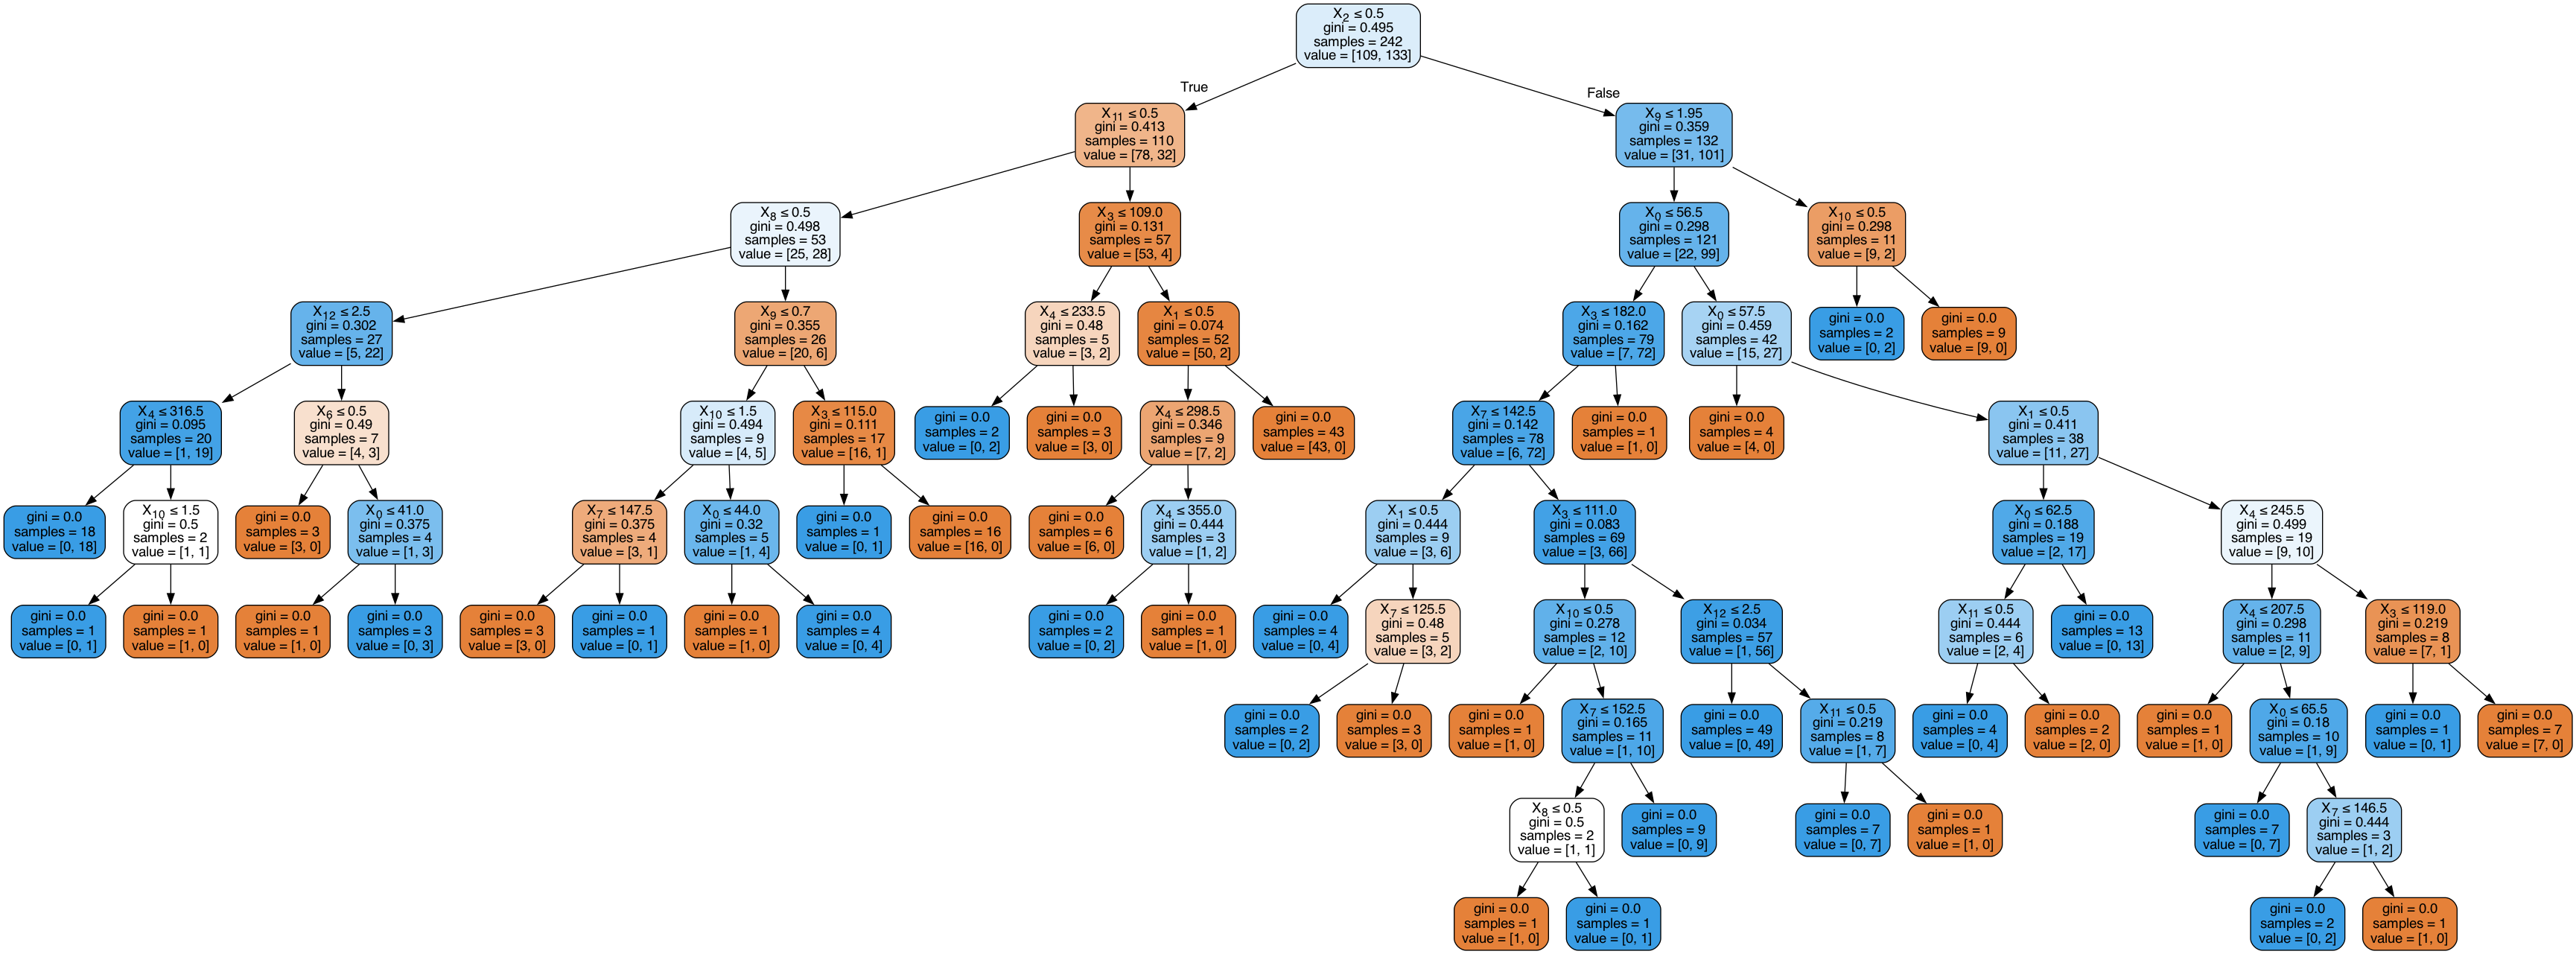

In [17]:
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

For each node:
+ The first line represents the decision rule. If true, take the left branch
+ The second line is the criterion for the split (e.g. Gini Impurity)
+ The third and fourth line show how many samples from the training set are in the current node and how they are divided.
+ Orange/Blue: Largest part of samples in the node heart disease is equal to 0/1
+ The darker the color, the more homogeneous the node.


In [18]:
x_test.join(y_test)[0:1]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
179,57,1,0,150,276,0,0,112,1,0.6,1,1,1,0


### Feature importance

In scikit-learn, is computed as the (normalized) total reduction of the criterion used for the split (here e.g. Gini)

In [19]:
df['importances_tree'] = model.feature_importances_
df.sort_values('importances_tree', ascending=False)

,feature,meaning,coefficient,odds,importances_tree
x2,cp,chest pain type,0.775056,2.170713,0.225263
x11,ca,number of major vessels (0-3) colored by fluoroscopy,-0.751114,0.471841,0.133084
x4,chol,serum cholesterol in mg/dl,-0.001414,0.998587,0.102953
x0,age,age of patient,0.007980,1.008012,0.100892
x9,oldpeak,ST depression induced by exercise relative to rest,-0.676346,0.508472,0.092402
x8,exang,exercise induced angina (1 = yes; 0 = no),-0.829017,0.436478,0.083767
x7,thalach,maximum heart rate achieved,0.027081,1.027451,0.061675
x10,slope,the slope of the peak exercise ST segment,0.618767,1.856637,0.059530
x3,trestbps,resting blood pressure (in mm Hg on admission to the hospital),-0.010965,0.989095,0.057994
x1,sex,"1 = male, 0 = female",-1.201090,0.300866,0.041015


<AxesSubplot: xlabel='importances_tree', ylabel='feature'>

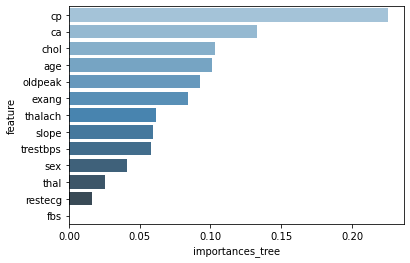

In [20]:
sn.barplot(x="importances_tree", y="feature", data=df.sort_values('importances_tree', ascending=False), palette="Blues_d")

### Do you stop here?

**NO!**

You could say that features like `cp`, `ca`, `chol` and `age` are really important in predicting a heart disease.
It’s possible they do, but first test your model!

Caveats: 
+ Keep in mind that feature importance here is based only on the training set and the current tree.
+ There are different ways to compute feature importance (see e.g. Random Forests)

# 3. Model-agnostic methods

We tend to use complex models (e.g. neural networks, gradient boosting etc.) because they outperform traditional models in terms of accuracy.

How do we interpret these models?
+ Permutation Feature Importance
+ Partial Dependence Plots (PDP)
+ Individual Conditional Expectation (ICE) plots
+ Local Interpretable Model-agnostic Explanations (LIME)
+ Shapley Additive Explanations (SHAP)
+ more?

## 3.1 Permutation Feature Importance

In DT we saw that "simple" feature importance is based on the mean decrease in a criterion (e.g. Gini for DT or RF or could be a form of error in general).

With the permutation technique, importance is based on measuring the increase of the prediction error when you permute the feature’s values.

So you compute the prediction error two times, before and after permutation of the feature.

The higher the difference between the prediction errors, the more important the feature is. Why? Because it means that the model depends on this feature to get good performance.

In [21]:
model = RandomForestClassifier(n_estimators=1000, random_state=1, max_depth=5)
model.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=1)

In [22]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print('Accuracy on train:  ' + str(accuracy_score(y_train, y_train_pred)))
print('Recall on train:    ' + str(recall_score(y_train, y_train_pred)))

print('Accuracy on test:   ' + str(accuracy_score(y_test, y_test_pred)))
print('Recall on test:     ' + str(recall_score(y_test, y_test_pred)))

Accuracy on train:  0.9504132231404959
Recall on train:    0.9849624060150376
Accuracy on test:   0.8688524590163934
Recall on test:     0.90625


In [23]:
df['importances_rf'] = model.feature_importances_

In [24]:
df.sort_values('importances_rf', ascending=False)

,feature,meaning,coefficient,odds,importances_tree,importances_rf
x11,ca,number of major vessels (0-3) colored by fluoroscopy,-0.751114,0.471841,0.133084,0.149635
x9,oldpeak,ST depression induced by exercise relative to rest,-0.676346,0.508472,0.092402,0.133810
x2,cp,chest pain type,0.775056,2.170713,0.225263,0.128034
x12,thal,3 = normal; 6 = fixed defect; 7 = reversable defect,-1.015574,0.362195,0.025328,0.113033
x7,thalach,maximum heart rate achieved,0.027081,1.027451,0.061675,0.100257
x8,exang,exercise induced angina (1 = yes; 0 = no),-0.829017,0.436478,0.083767,0.083404
x0,age,age of patient,0.007980,1.008012,0.100892,0.077142
x10,slope,the slope of the peak exercise ST segment,0.618767,1.856637,0.059530,0.053875
x3,trestbps,resting blood pressure (in mm Hg on admission to the hospital),-0.010965,0.989095,0.057994,0.051795
x4,chol,serum cholesterol in mg/dl,-0.001414,0.998587,0.102953,0.051588


<AxesSubplot: xlabel='importances_rf', ylabel='feature'>

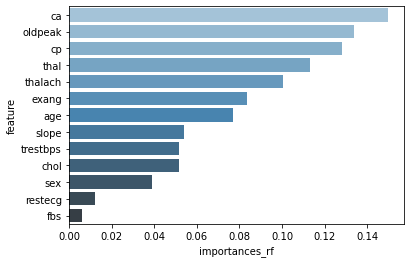

In [25]:
sn.barplot(x="importances_rf", y="feature", data=df.sort_values('importances_rf', ascending=False), palette="Blues_d")

### Permutation Feature Importance

In [26]:
perm = PermutationImportance(model).fit(x_test, y_test)
eli5.show_weights(perm)

Weight,Feature
0.0557 ± 0.0262,x2
0.0328 ± 0.0464,x11
0.0328 ± 0.0293,x7
0.0197 ± 0.0482,x9
0.0164 ± 0.0207,x12
0.0131 ± 0.0131,x6
0.0066 ± 0.0161,x10
0.0033 ± 0.0131,x1
0 ± 0.0000,x5
0 ± 0.0000,x3


### What can you say here?

* Try to exclude `chol` (x4) and `exang` (x8), because when these features are permuted the model performs better!

* For the features `fbs` (x5), `trestbps` (x3) there seems to be no effect on the model.

## 3.2 Partial Dependence Plot

These plots help visualize the average partial relationship between the predicted target and one or more features.

The process to create the plots is as follows:
+ Force all the instances to have the same feature value.
+ Make predictions for these instances and average them.
+ This gives the average prediction for this feature value.

This method gives you nice visualizations but most of the time only 1-2 features are investigated.


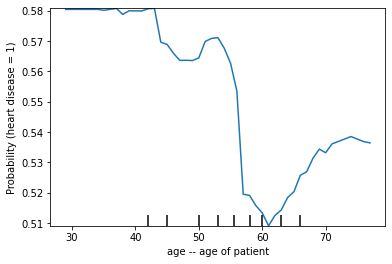

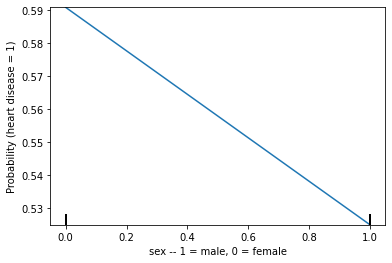

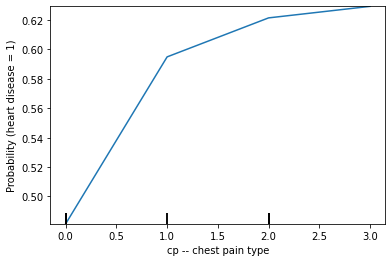

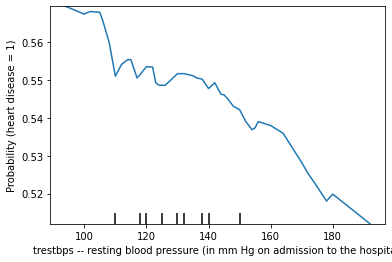

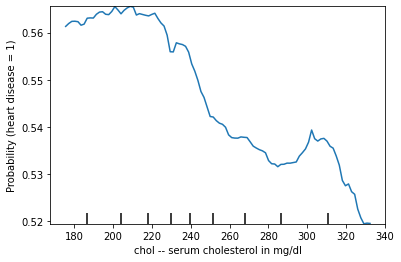

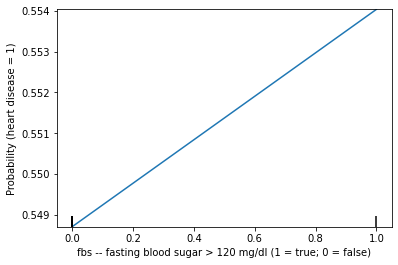

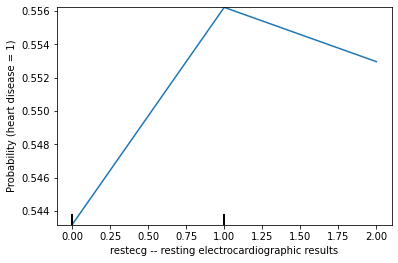

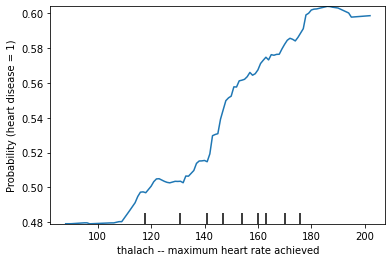

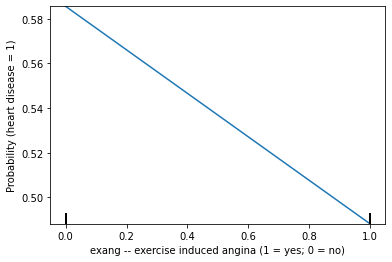

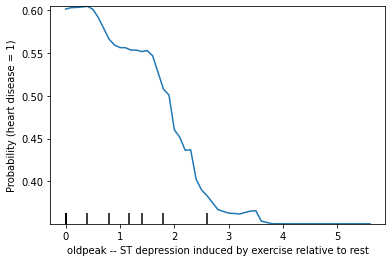

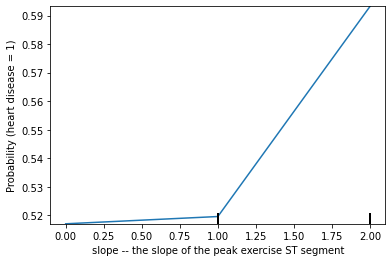

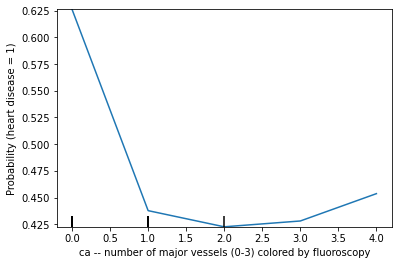

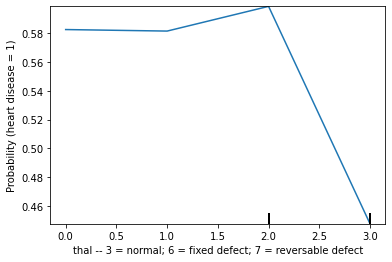

In [27]:
from sklearn.inspection import plot_partial_dependence

for i in range(len(x_train.columns)):
    plot_partial_dependence(model, x_train, [i])
    plt.xlabel(x.columns[i] + ' -- ' + cols_meaning[i])
    plt.ylabel('Probability (heart disease = 1)')
    plt.show()

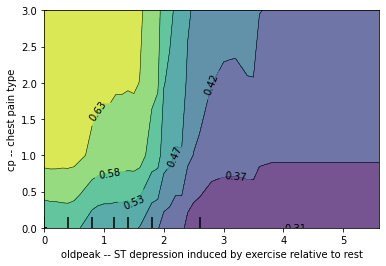

In [28]:
i = 9
j = 2

plot_partial_dependence(model, x_train, [(i,j)])
plt.xlabel(x.columns[i] + ' -- ' + cols_meaning[i])
plt.ylabel(x.columns[j] + ' -- ' + cols_meaning[j])
plt.show()

When chest pain type (`cp`) is equal to 1, 2 or 3 and `oldpeak` has a low value, the probability having a heart disease is much higher (> 0.63) than when cp is equal to 0 and oldpeak has a high value (< 0.37).


### PDP caveats

You force all the instances to have the same feature value. The plots can be misleading if you only have a small amount of instances that have a certain feature value. It’s better to include data distributions in your plot, so you can see if the data are equally distributed.

It is assumed that features for which you compute the partial dependence are independent. So they shouldn’t be correlated with other features. You can also easily miss complexity of the model, because the predictions are averaged.


## 3.3 Individual Conditional Expectation

ICE plots are more detailed than PDP and show how the prediction of *each* instance changes when a feature value is changed.

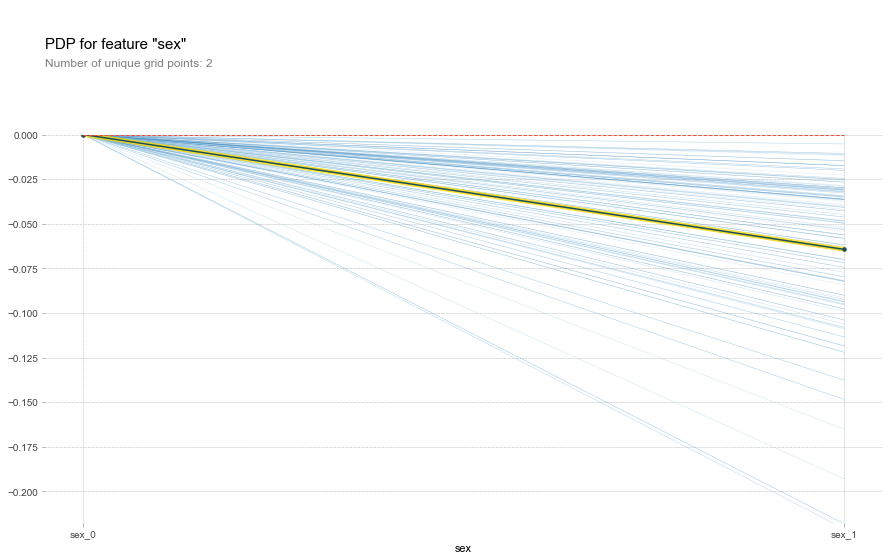

In [29]:
feature = 'sex'

pdp_ = pdp.pdp_isolate(
    model=model,
    dataset=data,
    model_features=df['feature'],
    feature=feature)

fig, axes = pdp.pdp_plot(pdp_, feature, center=True, plot_lines=True, frac_to_plot=100) #plot_pts_dist=True) #plot_pts_dist=True)

Explanation:
    
+ Each blue line is an instance.
+ You see that for some instances the prediction changes a lot when sex is changed to male, but for some instances the prediction almost stays the same, although it always has a negative effect to be female.

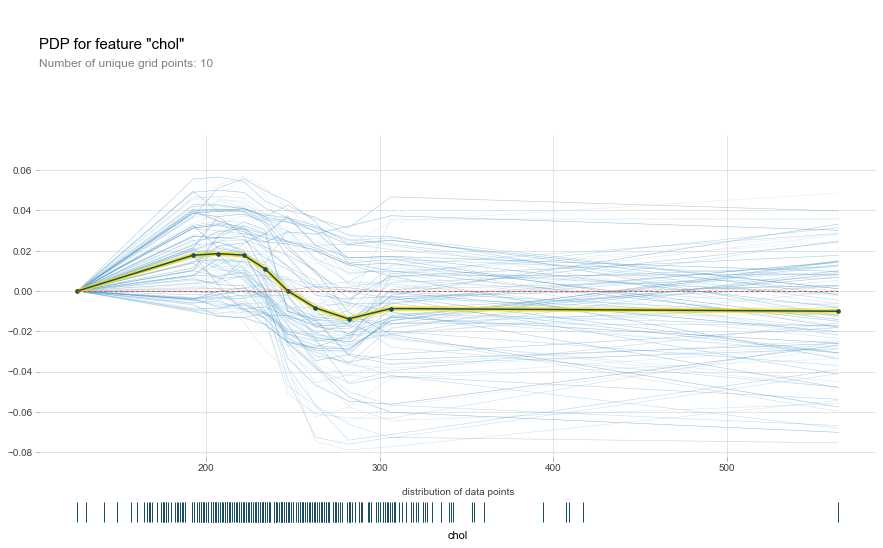

In [30]:
feature = 'chol'

pdp_ = pdp.pdp_isolate(
    model=model, dataset=data, model_features=df['feature'], feature=feature
)

fig, axes = pdp.pdp_plot(pdp_, feature, center=True, plot_lines=True, frac_to_plot=100, plot_pts_dist=True)

## 3.4 LIME

With LIME, a local surrogate model is trained. This interpretable surrogate model can be used to explain the individual prediction.

You can use LIME not only on tabular data, but also on images or text.

### LIME intuitive explanation

The steps are as follows:

1. Sample points around $x_i$ (the point that I want to interpret)
+ I use my big/complex model to predict labels for each sample 
+ I weigh samples according to the distance from $x_i$
+ Learn a new simple model (e.g. decision tree or linear regression) on weighted samples
+ Use simple model to explain the decision

In [31]:
explainer = lime_tabular.LimeTabularExplainer(x_train.values,
                                              feature_names=x_train.columns,
                                              class_names=['false', 'true'])

In [32]:
i = 31 #np.random.randint(0, x_test.shape[0])
print('Case:  ' + str(i))
print('Label: ' + str(y_test.iloc[i]))
npxtest = x_test.values
exp = explainer.explain_instance(npxtest[i], model.predict_proba, num_features=13, top_labels=1)

Case:  31
Label: 0


In [33]:
x_test.join(y_test)[31:32]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
284,61,1,0,140,207,0,0,138,1,1.9,2,1,3,0


In [34]:
exp.show_in_notebook(show_table=True)

### LIME caveats

+ If you explain the same record twice, the explanations can be different!

+ You can only explain one instance, so it’s not possible to interpret the whole black box model.


## 3.5 SHAP (SHapley Additive exPlanations)

Shapley Values (Game Theory): Each feature value of the instance is “player” in a “game” where the prediction is the “payout”.

Each feature is assigned an importance value for a particular prediction. More specifically SHAP assigns each feature an importance value for a particular prediction to compute the explanation. This value is the unified measure of additive feature attributions and is called SHAP value, $\phi_i \in \mathbb{R}$. The formula for $\phi_i$ is:

$$
\phi_i = \sum_{S \in F \setminus{\{i\}}} \frac{|S|!(M-|S|-1)!}{M!} [ f_{S \cup\{i\}}(x_{S \cup\{i\}})  - f_S(x_S)]  
$$

where:<br>
+ $F$ is the set of input features,<br>
+ $S$ is a subset of input features, <br>
+ $M = |F|$ is the number of input features.

This formula computes the gravity of each feature by calculating its importance when it is present in the prediction and then subtracting it when it is not present. Moreover,

+ $f_{S \cup\{i\}}(x_{S \cup\{i\}})$ is the output when the $i$-th feature is present
+ $f_S(x_S)$ is the output when the $i$-th feature is withheld
+ $\sum_{S \in F \setminus{\{i\}}} \frac{|S|!(M-|S|-1)!}{M!}$ is the weighted average of all possible subsets of $S$ in $F$

In [35]:
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)

i = 23
pred = model.predict(x_test.iloc[i].values.reshape(1,-1))[0]
print('Case:  ' + str(i))
print('Label: ' + str(y_test.iloc[i]))
print('Pred:  ' + str(pred))
shap.force_plot(explainer.expected_value[y_test.iloc[i]], shap_values[1][i], x_test.iloc[i], feature_names=x_train.columns)

Case:  23
Label: 1
Pred:  1


We see which features contribute towards "pushing" the model output from the base value (the average model output over the training dataset we passed) to the model output.

Red features, like `cp` and `ca` increase the probability having a heart disease, while `age` and `sex` decrease the probability.

If we take all instances from the test set (there are 61 in total), stack them and order them by similarity, we get the image below.

In [36]:
shap.force_plot(explainer.expected_value[1], shap_values[1], x_test, feature_names=x_train.columns)

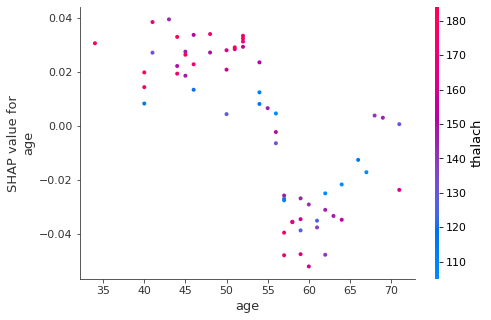

In [37]:
shap.dependence_plot("age", shap_values[1], x_test)

The summary plot shows the different SHAP values for high or low feature values.

For `ca` feature:

When this feature has a low value, the SHAP value is high, which means a higher probability having a heart disease.
This plot also shows us the most important features to the least important ones (top to bottom).


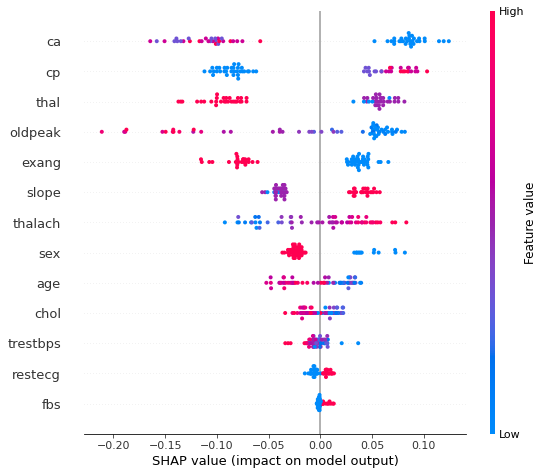

In [38]:
shap.summary_plot(shap_values[1], x_test)

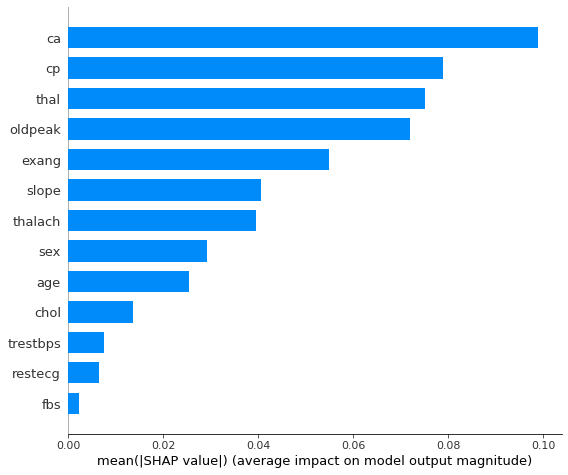

In [39]:
shap.summary_plot(shap_values[1], x_test, plot_type="bar")

### SHAP caveats

(+)
+ We can use it for local and global explanations.
+ Has a strong theoretical foundation.
+ Recent research has showed that they can work with dependent features.


(-)
+ Computation speed can be very slowwwww (especially with many features)
